# 08/05/15  Theano day!  

## Notes on the theano day organized in the group by James, Zhenwen and Andreas.

## Written by Alessandra Tosi, Fariba Yusefi and Javier Gonzalez

In [35]:
# Import Theano to start! 
import theano
import GPy
from theano import tensor as T
import numpy as np

## 1. Getting started

In [36]:
# Create a two dimensioanal array
X = T.matrix()

In [37]:
# Sum of the elements (even when is empty)
f = T.sum(T.square(X))
f

Sum{acc_dtype=float64}.0

In [38]:
# Define theano function using f and X
my_func = theano.function([X], f) 

In [39]:
# Generate some values for X and evaluate
X_values = np.random.randn(3,4)
my_func(X_values) 

array(22.902874531669156)

In [40]:
# Define gradients
g = theano.grad(f,X)

In [41]:
# Compute the derivarives
mu_new_func = theano.function([X], [f,g]) 

In [42]:
# Theano derivatives
mu_new_func(X_values)

[array(22.902874531669156),
 array([[ 2.81705389, -2.96814854, -1.07796816, -3.39275857],
        [ 0.83419848,  2.35849711, -3.15123663, -0.99206628],
        [-4.00459278,  2.67967031, -3.10533729,  3.48705811]])]

In [43]:
# Exact derivatives
X_values*2 

array([[ 2.81705389, -2.96814854, -1.07796816, -3.39275857],
       [ 0.83419848,  2.35849711, -3.15123663, -0.99206628],
       [-4.00459278,  2.67967031, -3.10533729,  3.48705811]])

## 2. Linear regression

In [44]:
# Define the elements of the regression
w = T.dvector()
Xw = T.dot(X,w)
y = T.dvector()
error = T.sum(T.square(y-Xw))
sigma = T.dscalar()
neg_log_lik = 0.5*y.size*np.log(2*np.pi) + 0.5*y.size*T.log(sigma**2) + 0.5*error/sigma**2 

In [45]:
# Create objective
my_func = theano.function([X, y, sigma, w], [neg_log_lik, theano.grad(neg_log_lik, w), theano.grad(neg_log_lik, sigma)]) 

In [46]:
# test with data
w_true = np.random.randn(2)
X_values = np.random.randn(200,2)   
y = np.dot(X_values, w_true) + np.random.randn(200)*0.01
y_values = np.dot(X_values, w_true) + np.random.randn(200)*0.01

In [47]:
# evaluate likelihood, gradiends with respect to w and gradients with respect to sigma
my_func(X_values, y_values , 0.02, np.array([1,1])) 

[array(721107.426408039),
 array([-578313.94337389,  726818.37581094]),
 array(-72160604.33024837)]

## 3. Team work (Alessandra, Fariba and Javier): implementing an RBF kernel in GPy using theano

In [48]:
# elements of the kernel
X   = T.matrix()
Z   = T.matrix()
len_scale  = T.dscalar()
sigma2  = T.dscalar()

In [49]:
# create the RBF kernel
r2 = ((X[:,None,:]/len_scale - Z[None,:,:]/len_scale)**2).sum(2)
rbf_kernel = sigma2*T.exp(-0.5*r2)

In [50]:
# Create the theano functions for r2 and the kernel
r2_eval   = theano.function([X,Z,len_scale],[r2])
kern_eval = theano.function([X,Z,len_scale,sigma2],[rbf_kernel])

In [51]:
# Generate some data to evaluate r2 and the kernel
X_val = np.random.randn(4,2)
Z_val = np.random.randn(6,2)
sigma2_val  = 1
len_scale_val = 2

In [52]:
# Distances evaluation!!! Order of the arguments should match
r2_eval(X_val,Z_val,len_scale_val)

[array([[ 0.26607691,  1.400719  ,  0.40145121,  1.07639693,  0.78777527,
          0.03459216],
        [ 2.2029816 ,  4.24934574,  2.49326402,  1.27425374,  3.50697369,
          1.41716478],
        [ 0.62534619,  0.09477583,  0.74934099,  1.51697373,  0.6041346 ,
          0.52550111],
        [ 1.95494282,  0.28702501,  2.2415506 ,  0.96016477,  2.11878424,
          1.39233886]])]

In [53]:
# Kernel evaluation
kern_eval(X_val,Z_val,len_scale_val,sigma2_val)

[array([[ 0.87543143,  0.49640681,  0.81813689,  0.58379904,  0.67442983,
          0.98285264],
        [ 0.33237521,  0.11947204,  0.28747137,  0.52880958,  0.17316908,
          0.49234165],
        [ 0.731489  ,  0.95371737,  0.68751578,  0.46837461,  0.73928831,
          0.76893368],
        [ 0.37626131,  0.86630997,  0.32602693,  0.61873242,  0.34666648,
          0.49849116]])]

In [54]:
# We check that it matches with the same GPy kernel

In [55]:
kernelGPy = GPy.kern.RBF(2, variance = sigma2_val, lengthscale=len_scale_val)

In [56]:
kernelGPy.K(X_val,Z_val)

array([[ 0.87543143,  0.49640681,  0.81813689,  0.58379904,  0.67442983,
         0.98285264],
       [ 0.33237521,  0.11947204,  0.28747137,  0.52880958,  0.17316908,
         0.49234165],
       [ 0.731489  ,  0.95371737,  0.68751578,  0.46837461,  0.73928831,
         0.76893368],
       [ 0.37626131,  0.86630997,  0.32602693,  0.61873242,  0.34666648,
         0.49849116]])

So, it works!

In [57]:
# We calculate the derivatives of our kernel with respect to sigma2
dL_dK = T.matrix()
h =  T.sum(dL_dK * rbf_kernel) 

In [58]:
# Define gradients with respect to sigma2
grads_wrt_sigma2 = theano.grad(h,sigma2)
grads_wrt_sigma2_eval = theano.function([X,Z,len_scale,sigma2,dL_dK],grads_wrt_sigma2)

In [59]:
# Define gradients with respect to the lengthscale
grads_wrt_lengthscale = theano.grad(h,len_scale)
grads_wrt_lengthscale_eval = theano.function([X,Z,len_scale,sigma2,dL_dK],grads_wrt_lengthscale)

In [60]:
# Define gradients with respect to X
grads_wrt_X= theano.grad(h,X)
grads_wrt_X_eval = theano.function([X,Z,len_scale,sigma2,dL_dK],grads_wrt_X)

In [61]:
# All gradients together
grads_all_eval = theano.function([X,Z,len_scale,sigma2,dL_dK], [grads_wrt_sigma2, grads_wrt_lengthscale, grads_wrt_X])

In [62]:
# We test the result in a simple GPy model
import GPy
from matplotlib import pyplot as plt

In [63]:
# Some data
x = np.linspace(-np.pi, np.pi, 201)[:,None]
y = np.sin(x) + np.random.rand(201)[:,None]

Populating the interactive namespace from numpy and matplotlib


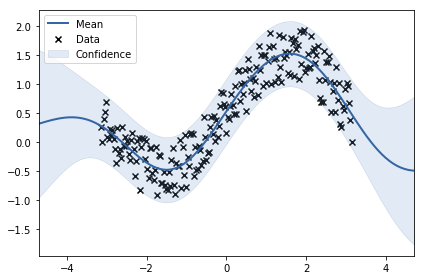

In [64]:
# plot the model
%pylab inline
model = GPy.models.GPRegression(x,y)
model.optimize()
model.plot()

In [65]:
## Class of kernels for GPy using theano (that uses our grads_all_eval)

class TheanoKern(GPy.kern.Kern):
    def __init__(self, input_dim, variance=1., lengthscale=1.):
        GPy.kern.Kern.__init__(self, input_dim, active_dims=None, name='theanokern')
        self.var = GPy.core.Param('variance', variance)
        self.ls = GPy.core.Param('lengthscale', lengthscale)
        self.link_parameters(self.var, self.ls)
        # Add here a function which initializes all the theano symbolic functions
        
    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        return kern_eval(X, X2, self.ls[0], self.var[0])[0]
    
    def Kdiag(self, X):
        return np.diag(self.K(X))
    
    def update_gradients_full(self, dL_dK, X, X2=None):
        if X2 is None:
            X2 = X
        dvar, dl, dX = grads_all_eval(X, X2, self.ls[0], self.var[0], dL_dK)
        self.var.gradient = dvar
        self.ls.gradient = dl 
    
    def gradients_X(self, dL_dK, X, X2=None):
        if X2 is None:
            X2 = X
        return grads_wrt_X_eval(X, X2, self.ls[0], self.var[0], dL_dK)
    
    def update_gradients_diag(self, dL_dKdiag, X):
        pass

In [66]:
# Create our theano kernel
k = TheanoKern(2)
k.K(X_val)

array([[  1.00000000e+00,   1.31316871e-01,   2.03090398e-01,
          3.73345538e-02],
       [  1.31316871e-01,   1.00000000e+00,   1.35581648e-03,
          5.27182798e-04],
       [  2.03090398e-01,   1.35581648e-03,   1.00000000e+00,
          3.94633570e-01],
       [  3.73345538e-02,   5.27182798e-04,   3.94633570e-01,
          1.00000000e+00]])

In [67]:
# model
m = GPy.models.GPRegression(x, y, kernel=TheanoKern(1))

In [68]:
# Ckeck with the gradients
m.checkgrad(1)

                   Name                   |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
--------------------------------------------------------------------------------------------------------------------------
 GP_regression.theanokern.variance        |   1.000000    |   0.000000    |   1.896706    |   1.896706    |     2e-08     
 GP_regression.theanokern.lengthscale     |   1.000000    |   0.000000    |   -5.834963   |   -5.834963   |     6e-08     
 GP_regression.Gaussian_noise.variance    |   1.000000    |   0.000000    |   56.521148   |   56.521148   |     6e-07     


True

Done! :)